In [69]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


0. Загрузка данных
-----------

Эту часть можно пропустить, результаты будут ниже.


Тренировочные и тестовые данные загружаются в словари словарей `data_train` и `data_test` соответственно

In [70]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('white')
import folder_handling as fh
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2

In [71]:
import nearest_neighbour as nn
reload(nn)

<module 'nearest_neighbour' from 'nearest_neighbour.pyc'>

In [72]:
path = "../../images/color_experiments/experiment_3/no_lightening/"

In [73]:
def load_images(path,type_to_load="train"):
    path_indicators = fh.get_path_contents(path)
    
    data = OrderedDict()
    for pi in path_indicators:
        data[os.path.basename(pi)] = OrderedDict()
        
        for illum in fh.get_path_contents(pi):
            data[os.path.basename(pi)][os.path.basename(illum)] = OrderedDict()
            for gradation in fh.get_path_contents(os.path.join(illum,type_to_load)):
                img = cv2.imread(gradation)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                name = os.path.splitext(os.path.basename(gradation))[0]
                data[os.path.basename(pi)][os.path.basename(illum)][name] = img
                
    return data

In [74]:
data_train = load_images(path)

In [75]:
data_test = load_images(path,type_to_load="test")

1. Тренировочные и тестовые картинки
--------------------

Ниже выведены все картинки, которые были взяты в тренировочный и в тестовый набор. Это такие типы индикаторов, как LEU, NIT, URO, PRO, BLO

In [76]:
def plot_all_images():
    for ind_type in data_train:
        for illumination_name,images in data_train[ind_type].iteritems():
            plt.figure(figsize=(12,2))
            for i,(class_name,img) in enumerate(images.iteritems()):
                plt.subplot(1,len(images),i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name)

            plt.suptitle('{} {} train'.format(ind_type,illumination_name))

            plt.figure(figsize=(12,2))
            images_test = data_test[ind_type][illumination_name]
            for i,(class_name,img) in enumerate(images_test.iteritems()):
                plt.subplot(1,len(images_test),i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name)
            plt.suptitle('{} {} test'.format(ind_type,illumination_name))
    plt.show()

In [77]:
#plot_all_images()

2. Алгоритм распознавания 
------------------

Была предложена идея распознавать цвет на тестовом изображении с помощью метрического алгоритма одного ближайшего соседа - т.е. искать в тренировочном наборе, относящемся к тому же типу освещенности и индикатору, что и тестовое изображение, ближайшую картинку.


### Описание функций:

В данном файле представлена версия алгоритма ближайшего соседа, взятая из ноутбука **col_exp_3.ipynb**.

 - Проработана реализация метрики: функции типа <font color = 'blue'>**get_distance**</font> берёт на вход две картинки -> и считает по ним метрику.
 
 - добавлена функция <font color='blue'>**preprocessing**</font>, которая принимает в качестве аргумента изображение и возвращает изображение.
 
 - функция <font color='blue'>**one_nearest_neighbor**</font> принимает на вход словарь `train_images` со значениями {класс : изображение}, `test_image`, функцию  <font color = 'blue'>**get_distance**</font>, <font color='blue'>**preprocessing**</font>:
 
 * после чего происходит предобработка тестового изображения и тренировочных, а затем применяется алгоритм поиска ближайшего соседа

### Что хочется попробовать: 
 
 
В качестве признаков для обучающего и тестового набора изображений были выбраны:

- средние значения по каналам RGB
- медианные значения по каналам RGB
- средние значения по каналам LAB
- медианные значения по каналам LAB
- некоторые алгоритмы предобработки тестовых и обучающих изображений - Гауссовы фильтры, бокс-фильтры

In [83]:
 def get_distance(img1,img2):
        
        point1 = np.mean(img1,axis=(0,1))
        point2 = np.mean(img2,axis=(0,1))
        d = 0.
        for i in xrange(point1.shape[0]):
            d += (point1[i] - point2[i])**2
        return np.sqrt(d)
    
def get_manhattan_distance(img1,img2):
    
    point1 = np.mean(img1,axis=(0,1))
    point2 = np.mean(img2,axis=(0,1))
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += np.abs(point1[i] - point2[i])
        
    return d

def get_frobenius_distance(img1,img2):
    if img1.shape[0]<=img2.shape[0]:
        i,j,k = img1.shape
        
        img2 = cv2.resize(img2, img1.shape[:2])
    else:
        i,j,k = img2.shape
        
        img1 = cv2.resize(img1, img2.shape[:2])
        
    
    return np.linalg.norm(img1-img2)

def get_hsv

In [84]:
def preprocessing(img):
    #img = cv2.blur(img,(5,5))
    return img

### Тестирующий класс:
   - содержит **поля**:
       - ``mistakes_strict`` - список с ошибочными объектами при строгом отборе 
       - `mistakes_soft` - список с ошибочными объектами при мягком отборе (отклонение в классе не более чем на 1)
       - `well_predicted_strict` - вспомогательные поля - правильно ли предсказана метка класса при строгом отборе
       - `well_predicted_soft` - вспомогательные поля - хорошо или плохо сделана классификация при мягком отборе
       - `prob_mistakes` - распределение вероятностей класса на ошибочно предсказанных объектах при строгом отборе
   - **методы**:
       - <font color = 'blue'> test </font>: (data_train,data_test,get_distance,preprocessing): тестирует нужную функцию
       - <font color = 'blue'> get_acc_strict </font>: возвращает точность при строгом отборе
       - <font color = 'blue'> get_acc_soft </font>: возвращает точность при мягком отборе
       - <font color = 'blue'> get_mistakes_strict</font>: возвращает список ошибок
       - <font color = 'blue'> get_mistakes_soft</font>: возвращает список ошибок
       - <font color = 'blue'> print_report</font>: печатает отчёт о тесте

In [85]:
tester = nn.TestDistancePreprocessing()

tester.test(data_train=data_train,data_test=data_test,
            get_distance=get_frobenius_distance,
            preprocessing=preprocessing)

In [86]:
tester.print_report()

Точность в предсказании верного класса:
 19.0 %
Точность в предсказании класса с отклонением не более: 1
 47.7 %


In [87]:
for item in tester.mistakes_strict:
    indicator_type, illumination, true_class, predicted_class = [x.split(':')[-1] for x in item]
    
    train_images = data_train[indicator_type][illumination]
    test_image = data_test[indicator_type][illumination][true_class]
    predicted_class = nn.one_nearest_neighbor(train_images,test_image,
                           get_distance=get_frobenius_distance,
                           preprocessing=preprocessing,
                           verbose=True)
    print predicted_class

all distances: [2081.9380394238442, 3092.7271137298876, 2471.2581815747217, 2870.3884754506662, 1547.3842444590161, 2917.1708897491762, 3305.7111186551074]
predicted class: 5

5
all distances: [3901.3878299907587, 4145.2100067427227, 2999.5486327112617, 3564.9180916256687, 1872.1920307489827, 2978.7799515909192, 2978.0493615788173]
predicted class: 5

5
all distances: [3709.1136407503072, 4045.9539048288725, 2262.2521963742238, 2070.750588554788, 1077.671564067643, 2375.0086315632625, 2912.7054433979415]
predicted class: 5

5
all distances: [4173.5335149007733, 5283.8453800239085, 5495.0406731888706, 5758.7162631961646, 4350.9515051308026, 2564.7898549393867, 1917.0276471663105]
predicted class: 7

7
all distances: [3601.9021363718366, 5153.6545285845459, 5385.4369367768113, 5266.0063615609124, 4207.7718569333101, 6603.6976005871138, 6168.7090221536628]
predicted class: 1

1
all distances: [4286.6320112647882, 5055.5173820292621, 3876.2252256544639, 3874.5022906174672, 2981.50817540385

In [39]:
indicator_type = 'BLO'
illumination_name = 'illum_3'
true_class = '3'
test_img = data_test[indicator_type][illumination_name][true_class]

train_images = data_train[indicator_type][illumination_name]

print "predicted class:",nn.one_nearest_neighbor(train_images,test_img,
                                             preprocessing=preprocessing,
                                             get_distance=get_distance)

print "true class:",true_class

predicted class: 2
true class: 3


### Результаты
- Переход в HSV и евклидова метрика с подсчётом среднего в качестве признаков: 
   - Точность в предсказании верного класса
        73.1 %
        Точность в предсказании класса с отклонением не более 1
        96.2 %
         
- Переход в HSV и манхеттенское расстояние и среднее:
    - Точность в предсказании верного класса
         76.9 %
        Точность в предсказании класса с отклонением не более 1
         96.9 %
- Переход в HSV, manhattan, median: 
    - Точность в предсказании верного класса
         76.2 %
        Точность в предсказании класса с отклонением не более 1
         97.7 %
- LAB, Euclidean, median: 
    - Точность в предсказании верного класса
 71.5 %
    Точность в предсказании класса с отклонением не более 1
    98.5 %
- LAB, Euclidean, mean:
    - Точность в предсказании верного класса
 70.8 %
    Точность в предсказании класса с отклонением не более 1
    99.2 %
    
- LAB, manhattan, mean:
    - Точность в предсказании верного класса
 76.2 %
    Точность в предсказании класса с отклонением не более 1
     99.2 %
- LAB, manhattan, median:
    - Точность в предсказании верного класса
 74.6 %
    Точность в предсказании класса с отклонением не более 1
     98.5 %
- XYZ, manhattan or Euclidean, mean: 
    - Плохо - 60 %, 95%

**Промежуточный вывод:**

Пока, для всех алгоритмов полная точность составляет порядка 72 процентов попадания в ту же градацию. В большинстве случаев алгоритм ошибается на одну градацию (как в большую так и в меньшую стороны).


**Ниже выведены ошибочные варианты**:
За исключением индикатора "BLO", все остальные ошибки выглядят вразумительно.

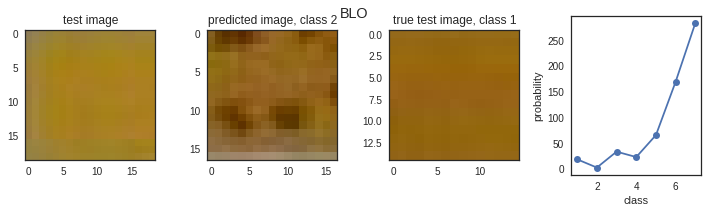

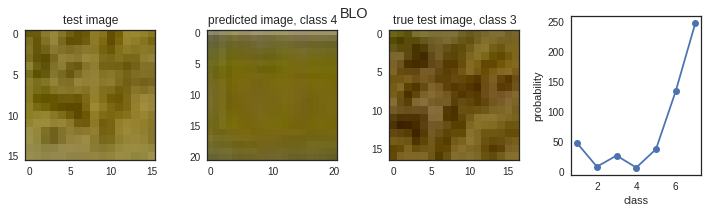

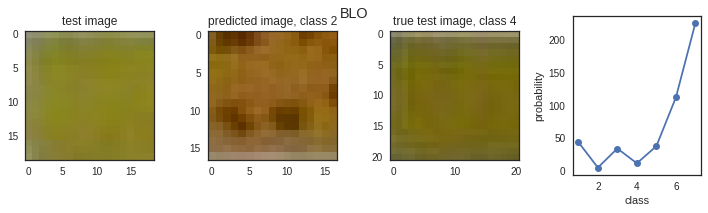

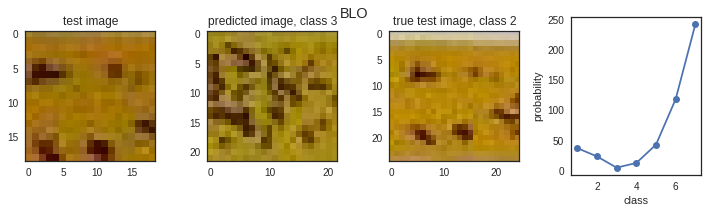

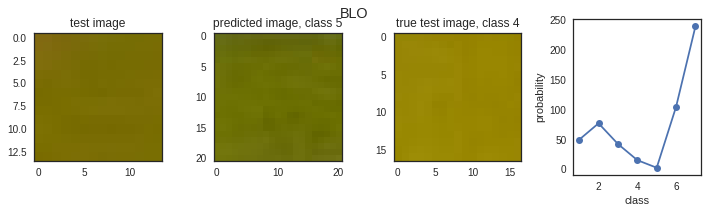

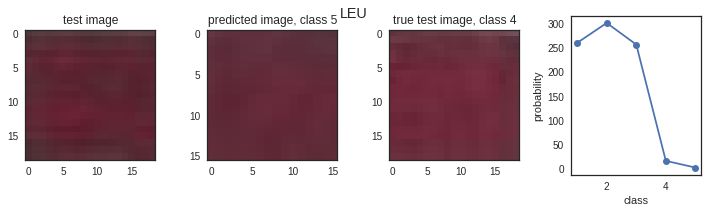

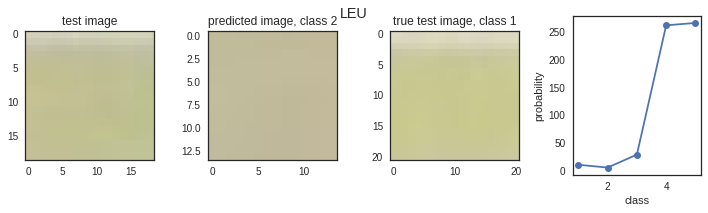

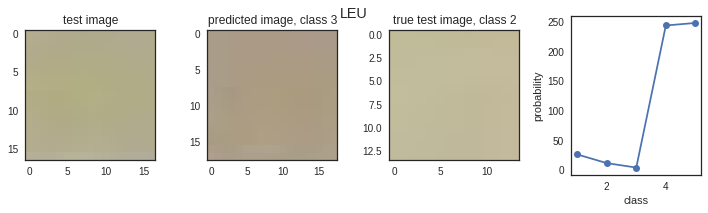

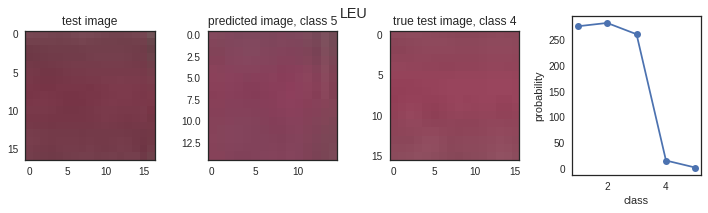

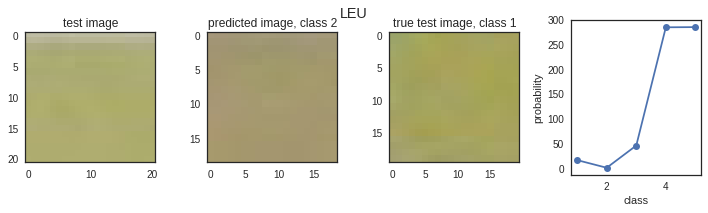

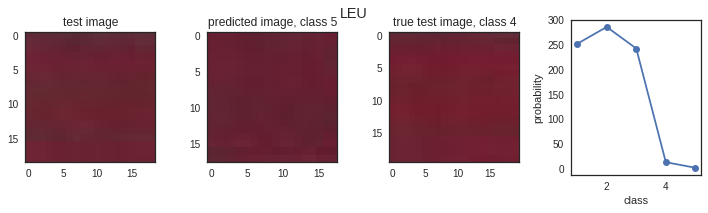

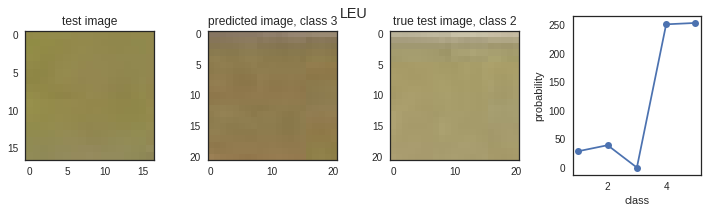

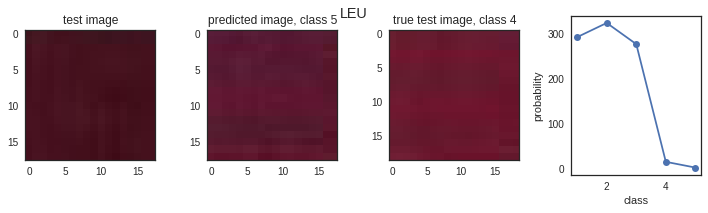

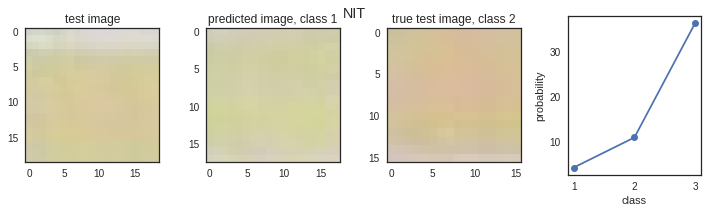

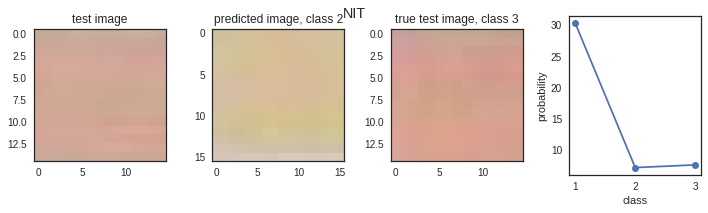

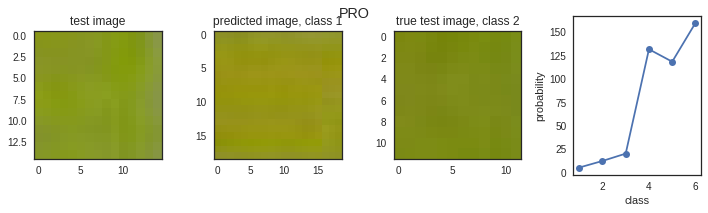

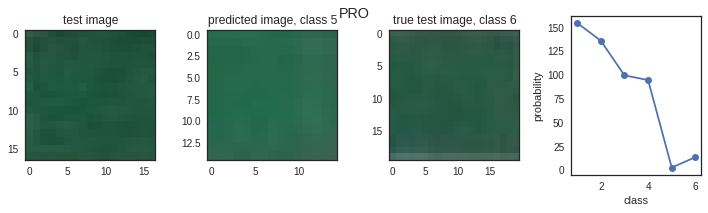

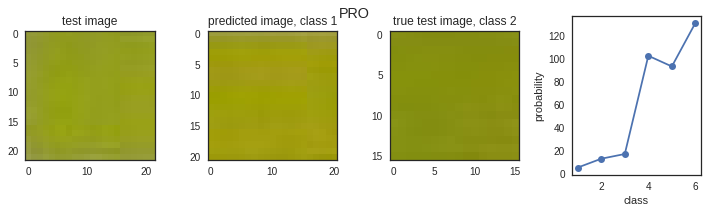

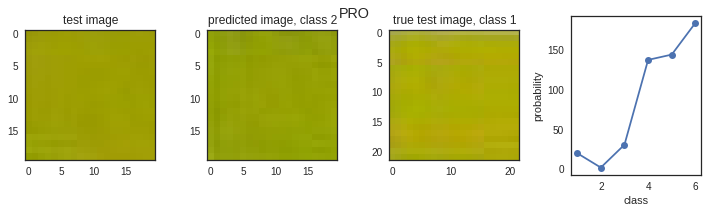

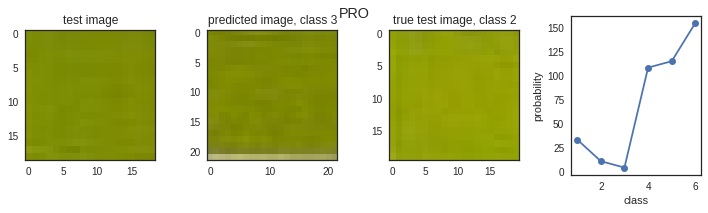

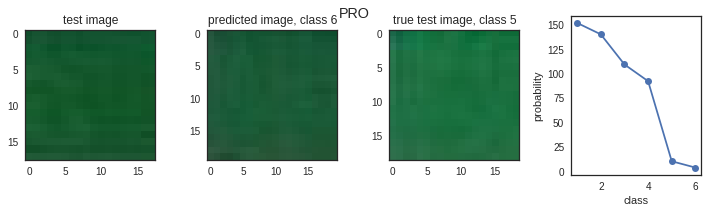

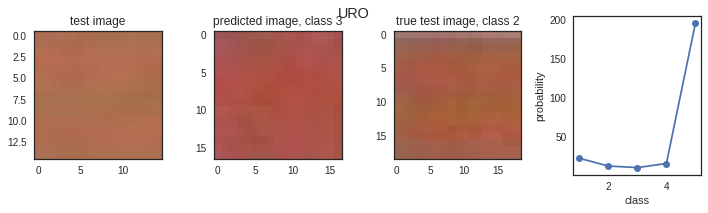

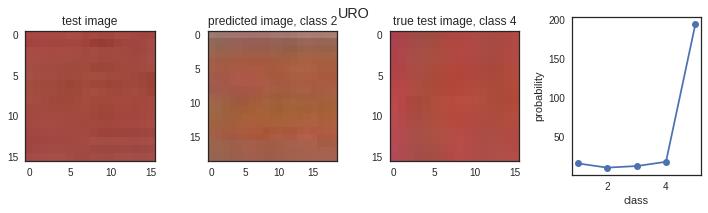

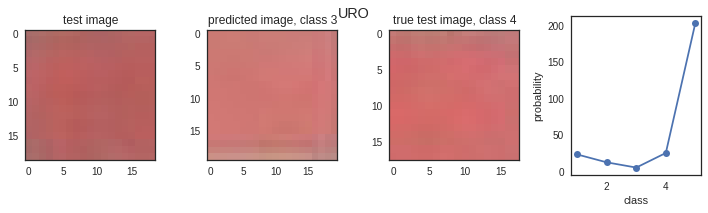

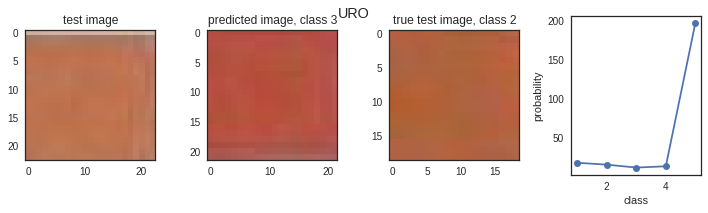

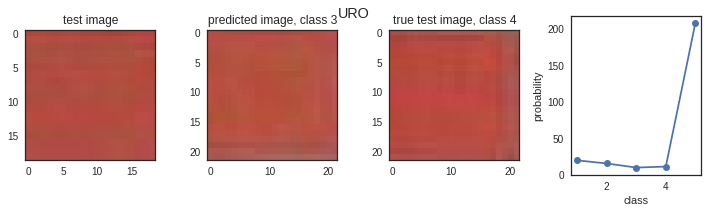

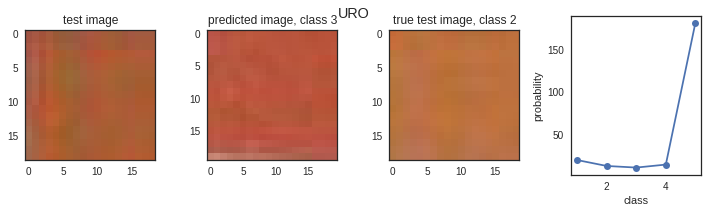

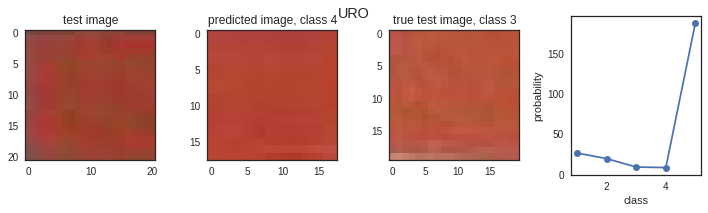

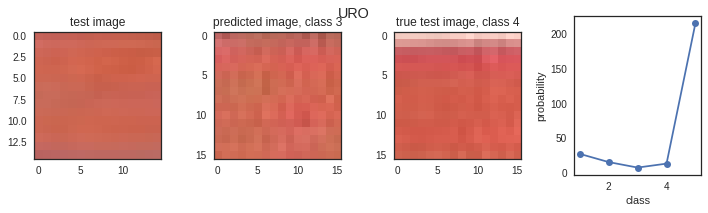

In [51]:
for item,p in zip(mistakes_strict,prob_mistakes):
        plt.figure(figsize=(10,3))
        ind_type, illum, true_class, predicted_class = [x.split(':')[-1] for x  in item]
        img_train_true = data_train[ind_type][illum][true_class]
        img_train_chosen = data_train[ind_type][illum][predicted_class]
        img_test = data_test[ind_type][illum][true_class]

        plt.subplot(1,4,1)
        plt.imshow(img_test)
        plt.title('test image')

        plt.subplot(1,4,2)
        plt.imshow(img_train_chosen)
        plt.title('predicted image, class {}'.format(predicted_class))

        plt.subplot(1,4,3)
        plt.imshow(img_train_true)
        plt.title('true test image, class {}'.format(true_class))

        plt.subplot(1,4,4)
        plt.plot(range(1,len(data_train[ind_type][illum])+1),-10*np.log(p),'o-')
        plt.xlabel('class')
        plt.ylabel('probability')
        
        plt.suptitle(ind_type)
        plt.tight_layout()
